In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Velocidades circulares - GADGET

In [2]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np

vector = ('00','01','03')
vector2 = ('M31', 'MW', 'M33')
h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

atime = np.loadtxt('/home/ornela/SimCLUES/redshift_outputs.txt')
aexp = atime[:,2]
aexp = aexp[::-1]

snapshot=range(496,495,-1)

for isnap in snapshot:
    snap = h5py.File('/home/ornela/SimCLUES/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    for i in range(0,2):
        cm   = snap['subhalo_0'+ str('%s'%vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s'%vector[i])+ '/R200'].value
        
        pstr = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        mstr = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s'%vector[i])+ '/Str/Velocities'].value
        
        pgas = snap['subhalo_0'+ str('%s'%vector[i])+ '/Gas/Coordinates'].value
        mgas = snap['subhalo_0'+ str('%s'%vector[i])+ '/Gas/Masses'].value
        
        pdrk = snap['subhalo_0'+ str('%s'%vector[i]) + '/Drk/Coordinates'].value
        mdrk = snap['subhalo_0'+ str('%s'%vector[i])+ '/Drk/Masses'].value
        
        z = a0/aexp[0] - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp[0]/h
        ystr = (pstr[:,1]-cm[1])*aexp[0]/h
        zstr = (pstr[:,2]-cm[2])*aexp[0]/h
        rstr = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = (pgas[:,0]-cm[0])*aexp[0]/h
        ygas = (pgas[:,1]-cm[1])*aexp[0]/h
        zgas = (pgas[:,2]-cm[2])*aexp[0]/h
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
        xdrk = (pdrk[:,0]-cm[0])*aexp[0]/h
        ydrk = (pdrk[:,1]-cm[1])*aexp[0]/h
        zdrk = (pdrk[:,2]-cm[2])*aexp[0]/h
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
         
        v_x = vel[:,0] *np.sqrt(aexp[0]) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp[0]) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp[0]) + Ht *zstr/1000.
#----------------------masas----------------------------
        mstr = mstr/h
        mgas = mgas/h
        mdrk = mdrk/h
        
        r200 = r200*aexp[0]/h
        
        print 'r200 =', r200
        rgal=0.15*r200
        
        limit    = np.where(rstr<rgal)
        r_sort   = np.sort(rstr[limit])
        r_indice = np.argsort(rstr[limit])
        
        limit_str   = np.where(rstr<r200)
        rstr_sort   = np.sort(rstr[limit_str])
        rstr_indice = np.argsort(rstr[limit_str])
        
        limit_gas   = np.where(rgas<r200)
        rgas_sort   = np.sort(rgas[limit_gas])
        rgas_indice = np.argsort(rgas[limit_gas])
        
        limit_drk   = np.where(rdrk<r200)
        rdrk_sort   = np.sort(rdrk[limit_drk])
        rdrk_indice = np.argsort(rdrk[limit_drk])
        
        
        Mgal_str = cumsum((mstr[limit])[r_indice])
        
        Mc_str = cumsum((mstr[limit_str])[rstr_indice])
        
        Mc_gas = cumsum((mgas[limit_gas])[rgas_indice])
        
        Mc_drk = cumsum((mdrk[limit_drk])[rdrk_indice])
        
#------------------ calculamos r90, r50------------------------------------------
        M_gal = Mgal_str[-1]
    
        razon      = Mgal_str/M_gal
        noventa,   = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r90 = r_sort[noventa]
        r50 = r_sort[cincuenta]
#--------------------------------------------------------------       
        rtot = concatenate([rstr, rgas, rdrk])
        mtot = concatenate([mstr, mgas, mdrk])
        
        limit_tot   = np.where(rtot<r200)
        rtot_sort   = np.sort(rtot[limit_tot])
        rtot_indice = np.argsort(rtot[limit_tot])
        
        Mc_tot = cumsum((mtot[limit_tot])[rtot_indice])
        
        #print 'Mvir=', Mc_tot[-1], 'r50=', r50[-1]
#--------------------------------------------------------------
        
        Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)
        Vstr = np.sqrt((G*Mc_str*1e10)/rstr_sort)
        Vgas = np.sqrt((G*Mc_gas*1e10)/rgas_sort)
        Vdrk = np.sqrt((G*Mc_drk*1e10)/rdrk_sort)
        
#----------------------------------------------------------------------------------

        data = np.zeros([np.size(rtot_sort),8])
        data[:np.size(rstr_sort),0]= rstr_sort 
        data[:np.size(rgas_sort),1]= rgas_sort
        data[:np.size(rdrk_sort),2]= rdrk_sort
        data[:np.size(rtot_sort),3]= rtot_sort
        data[:np.size(rstr_sort),4]= Vstr 
        data[:np.size(rgas_sort),5]= Vgas
        data[:np.size(rdrk_sort),6]= Vdrk
        data[:np.size(rtot_sort),7]= Vtot

        np.savetxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/'+str('%s'%vector2[i])+'_Vcirc.dat', data, fmt='%12.6f')

r200 = 167.210382514
r200 = 153.542349727


### Velocidades circulares - GASOLINE

In [3]:
#Graficamos la veloc circular pero con la flecha de V200 y solo para los 3 halos mas grandes
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np

vector = (1,2,4)
vector2 = ('M31', 'MW', 'M33')
G = 4.299e-6
a0 =1.
snapshot = np.loadtxt('/home/ornela/SimCLUES/Gasoline/snapshots.txt', dtype='string')


snap = h5py.File('/home/ornela/SimCLUES/Gasoline/outputs2/snap_1024.h5py', 'r')

for i in range(0,2):
    cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
    r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
    aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value
    h    = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value
    
    omega_lambda = snap['subhalo_00'+ str('%s' %vector[i])+ '/OmegaL0'].value
    omega_matter = snap['subhalo_00'+ str('%s' %vector[i])+ '/OmegaM0'].value

    pstr = snap['subhalo_00'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
    mstr = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Masses'].value
    vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value

    pgas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Coordinates'].value
    mgas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Masses'].value

    pdrk = snap['subhalo_00'+ str('%s' %vector[i]) + '/Drk/Coordinates'].value
    mdrk = snap['subhalo_00'+ str('%s' %vector[i])+ '/Drk/Masses'].value

    H0 = h*100
    z = a0/aexp - 1.
    omega0 = omega_lambda + omega_matter
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0]) #*aexp
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = (pgas[:,0]-cm[0])
    ygas = (pgas[:,1]-cm[1])
    zgas = (pgas[:,2]-cm[2])
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = (pdrk[:,0]-cm[0])
    ydrk = (pdrk[:,1]-cm[1])
    zdrk = (pdrk[:,2]-cm[2])
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

    #v_x = vel[:,0] *np.sqrt(aexp) + Ht *xstr/1000.
    #v_y = vel[:,1] *np.sqrt(aexp) + Ht *ystr/1000.
    #v_z = vel[:,2] *np.sqrt(aexp) + Ht *zstr/1000.
    
    v_x = vel[:,0] 
    v_y = vel[:,1] 
    v_z = vel[:,2]

#------------------------------------------------
    r200 = r200*aexp
    
    print 'r200=', r200
    rgal=0.15*r200

    limit    = np.where(rstr<rgal)
    r_sort   = np.sort(rstr[limit])
    r_indice = np.argsort(rstr[limit])

    limit_str   = np.where(rstr<r200)
    rstr_sort   = np.sort(rstr[limit_str])
    rstr_indice = np.argsort(rstr[limit_str])

    limit_gas   = np.where(rgas<r200)
    rgas_sort   = np.sort(rgas[limit_gas])
    rgas_indice = np.argsort(rgas[limit_gas])

    limit_drk   = np.where(rdrk<r200)
    rdrk_sort   = np.sort(rdrk[limit_drk])
    rdrk_indice = np.argsort(rdrk[limit_drk])


    Mgal_str = cumsum((mstr[limit])[r_indice])

    Mc_str = cumsum((mstr[limit_str])[rstr_indice])

    Mc_gas = cumsum((mgas[limit_gas])[rgas_indice])

    Mc_drk = cumsum((mdrk[limit_drk])[rdrk_indice])

#------------------ calculamos r90, r50------------------------------------------
    M_gal = Mgal_str[-1]

    razon = Mgal_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]
#--------------------------------------------------------------       
    rtot= concatenate([rstr, rgas, rdrk])
    mtot= concatenate([mstr, mgas, mdrk])

    limit_tot = np.where(rtot<r200)
    rtot_sort = np.sort(rtot[limit_tot])
    rtot_indice = np.argsort(rtot[limit_tot])
    
    Mc_tot = cumsum((mtot[limit_tot])[rtot_indice])


#calculo rvir------------------------------------------
    '''rho_crit=3*(H0/1000)**2/(8*pi*G)
    rho=Mc_tot1*3/(4*pi*rtot_sort1**3)
    delta=rho/rho_crit
    kk=np.where(delta<200)
    rvir=rtot_sort1[kk]
    print rvir[0],(delta[kk])[0]'''
#--------------------------------------------------------------
    Mc_tot = Mc_tot[1:]
    Mc_str = Mc_str[1:]
    Mc_gas = Mc_gas[1:]
    Mc_drk = Mc_drk[1:]

    rtot_sort = rtot_sort[1:]
    rstr_sort = rstr_sort[1:]
    rgas_sort = rgas_sort[1:]
    rdrk_sort = rdrk_sort[1:]

    Vtot = np.sqrt((G*Mc_tot)/rtot_sort)
    Vstr = np.sqrt((G*Mc_str)/rstr_sort)
    Vgas = np.sqrt((G*Mc_gas)/rgas_sort)
    Vdrk = np.sqrt((G*Mc_drk)/rdrk_sort)

#     Vvir = Vtot[-1]
    
    data = np.zeros([np.size(rtot_sort),8])
    data[:np.size(rstr_sort),0]= rstr_sort 
    data[:np.size(rgas_sort),1]= rgas_sort
    data[:np.size(rdrk_sort),2]= rdrk_sort
    data[:np.size(rtot_sort),3]= rtot_sort
    data[:np.size(rstr_sort),4]= Vstr 
    data[:np.size(rgas_sort),5]= Vgas
    data[:np.size(rdrk_sort),6]= Vdrk
    data[:np.size(rtot_sort),7]= Vtot

    np.savetxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs/_data/'+str('%s'%vector2[i])+'_Vcirc.dat', data, fmt='%12.6f')

r200= 166.840000002
r200= 150.460000002


In [2]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

#path = 'home/ornela/PYTHON/'
path = '/home/omarioni/'

M31_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_Vcirc.dat')
rstr_M31gd = M31_gd[:,0]
rgas_M31gd = M31_gd[:,1]
rdrk_M31gd = M31_gd[:,2]
rtot_M31gd = M31_gd[:,3]
Vstr_M31gd = M31_gd[:,4]
Vgas_M31gd = M31_gd[:,5]
Vdrk_M31gd = M31_gd[:,6]
Vtot_M31gd = M31_gd[:,7]

MW_gd  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/MW_Vcirc.dat')
rstr_MWgd = MW_gd[:,0]
rgas_MWgd = MW_gd[:,1]
rdrk_MWgd = MW_gd[:,2]
rtot_MWgd = MW_gd[:,3]
Vstr_MWgd = MW_gd[:,4]
Vgas_MWgd = MW_gd[:,5]
Vdrk_MWgd = MW_gd[:,6]
Vtot_MWgd = MW_gd[:,7]

M31_gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_Vcirc.dat')
rstr_M31gs = M31_gs[:,0]
rgas_M31gs = M31_gs[:,1]
rdrk_M31gs = M31_gs[:,2]
rtot_M31gs = M31_gs[:,3]
Vstr_M31gs = M31_gs[:,4]
Vgas_M31gs = M31_gs[:,5]
Vdrk_M31gs = M31_gs[:,6]
Vtot_M31gs = M31_gs[:,7]

MW_gs  = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_Vcirc.dat')
rstr_MWgs = MW_gs[:,0]
rgas_MWgs = MW_gs[:,1]
rdrk_MWgs = MW_gs[:,2]
rtot_MWgs = MW_gs[:,3]
Vstr_MWgs = MW_gs[:,4]
Vgas_MWgs = MW_gs[:,5]
Vdrk_MWgs = MW_gs[:,6]
Vtot_MWgs = MW_gs[:,7]

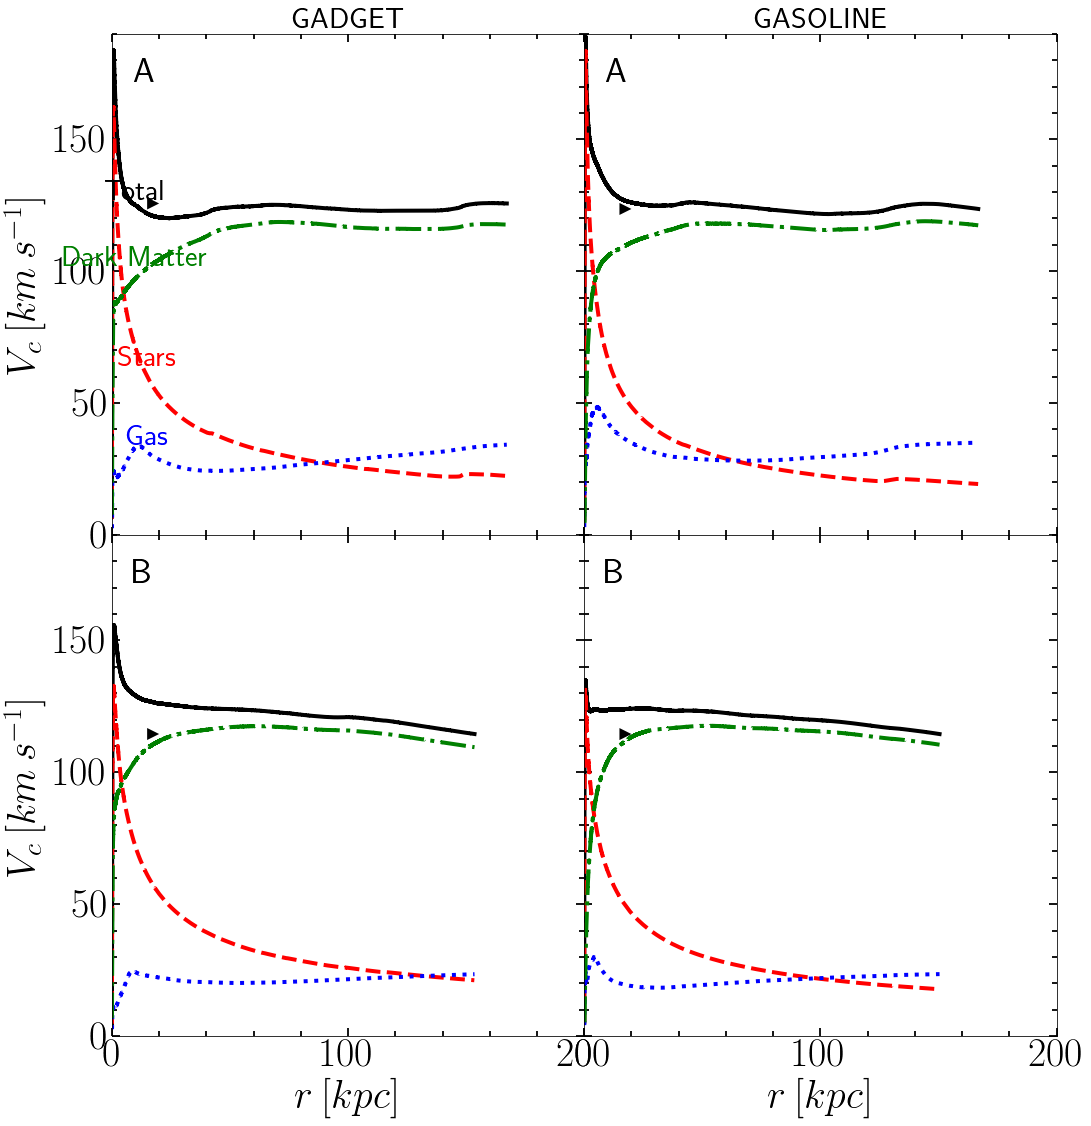

In [3]:
# fig=plt.figure(1,figsize=(16,16))
# fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.95, top = 0.95, wspace=0., hspace= 0)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.92, top = 0.95, wspace=0., hspace= 0)

# ax=fig.add_subplot(221)
ax[0,0].plot(rtot_M31gd[np.where(Vtot_M31gd!=0)],Vtot_M31gd[np.where(Vtot_M31gd!=0)],'-', lw=4, color='k', label= 'Total')
ax[0,0].plot(rstr_M31gd[np.where(Vstr_M31gd!=0)],Vstr_M31gd[np.where(Vstr_M31gd!=0)],'--',lw=4, color='r', label ='Stars')
ax[0,0].plot(rgas_M31gd[np.where(Vgas_M31gd!=0)],Vgas_M31gd[np.where(Vgas_M31gd!=0)],':', color ='b',lw=4, label='Gas')
ax[0,0].plot(rdrk_M31gd[np.where(Vdrk_M31gd!=0)],Vdrk_M31gd[np.where(Vdrk_M31gd!=0)],'-.',color='g', lw=4, label='Dark Matter')

ax[0,0].text(18, 175, 'A', fontsize=35, color='k', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
ax[0,0].set_xticklabels([])
# ax[0,0].set_xticks([0,5,10,15])
ax[0,0].set_ylabel(r'$V_{c}\:[km\:s^{-1}]$', fontsize=40)
ax[0,0].set_ylim(0,190)
ax[0,0].set_xlim(0,200)
ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=40)
ax[0,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax.annotate('', xy=(rgal,0), xytext=(rgal, 27), textcoords='data', 
#              fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.01),ha="center")
# ax.text(rgal, 32, '$r_{gal} =$'+ str('%.2f'%rgal), fontsize=20, color='black', 
#          ha='center', va='center')
ax[0,0].annotate('', xy=(20,Vtot_M31gd[np.where(Vtot_M31gd!=0)][-1]), xytext=(17, Vtot_M31gd[np.where(Vtot_M31gd!=0)][-1]), textcoords='data' ,ha="right", va='center',
             arrowprops=dict(facecolor='k',ec="none"))
# ax[0,0].text(17, Vtot_M31gd[np.where(Vtot_M31gd!=0)][-1], r'$V_{vir}$', fontsize=30, color='deeppink', ha='right', va='center')
ax[0,0].text(15, 37, 'Gas', fontsize=30, color='b', ha='center', va='center')
ax[0,0].text(15, 67, 'Stars', fontsize=30, color='r', ha='center', va='center')
ax[0,0].text(10, 105, 'Dark Matter', fontsize=30, color='g', ha='center', va='center')
ax[0,0].text(10, 130, 'Total', fontsize=30, color='k', ha='center', va='center')
ax[0,0].set_title('GADGET', loc='center', fontsize=30)

#------------------------------------------------------

# ax2=fig.add_subplot(222)
ax[0,1].plot(rtot_M31gs[np.where(Vtot_M31gs!=0)],Vtot_M31gs[np.where(Vtot_M31gs!=0)],'-', lw=4, color='k', label= 'Total')
ax[0,1].plot(rstr_M31gs[np.where(Vstr_M31gs!=0)],Vstr_M31gs[np.where(Vstr_M31gs!=0)],'--',lw=4, color='r', label ='Stars')
ax[0,1].plot(rgas_M31gs[np.where(Vgas_M31gs!=0)],Vgas_M31gs[np.where(Vgas_M31gs!=0)],':', color ='b',lw=4, label='Gas')
ax[0,1].plot(rdrk_M31gs[np.where(Vdrk_M31gs!=0)],Vdrk_M31gs[np.where(Vdrk_M31gs!=0)],'-.',color='g', lw=4, label='Dark Matter')

ax[0,1].text(18, 175, 'A', fontsize=35, color='k', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
# ax[0,1].set_xticks([0,5,10,15])
ax[0,1].set_ylim(0,190)
ax[0,1].set_xlim(0,200)
ax[0,1].minorticks_on()
ax[0,1].tick_params( labelsize=40)
ax[0,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax[0,1].annotate('', xy=(20,Vtot_M31gs[np.where(Vtot_M31gs!=0)][-1]), xytext=(17, Vtot_M31gs[np.where(Vtot_M31gs!=0)][-1]), textcoords='data', ha="right", va='center',
             arrowprops=dict(facecolor='k', ec="none"))
# ax[0,1].text(17, Vtot_M31gs[np.where(Vtot_M31gs!=0)][-1],  u'$V_{vir}$', 
#              fontsize=30, color='deeppink', ha='right', va='center')
# ax[0,1].text(43, 24, 'Gas', fontsize=30, color='b', ha='center', va='center')
# ax[0,1].text(43, 39, 'Stars', fontsize=30, color='r', ha='center', va='center')
# ax[0,1].text(40, 107, 'Dark Matter', fontsize=30, color='g', ha='center', va='center')
# ax[0,1].text(15, 135, 'Total', fontsize=30, color='k', ha='center', va='center')
ax[0,1].set_title('GASOLINE', loc='center', fontsize=30)


#---------------------------------------------------------

# ax3=fig.add_subplot(223)
ax[1,0].plot(rtot_MWgd[np.where(Vtot_MWgd!=0)],Vtot_MWgd[np.where(Vtot_MWgd!=0)],'-', lw=4, color='k', label= 'Total')
ax[1,0].plot(rstr_MWgd[np.where(Vstr_MWgd!=0)],Vstr_MWgd[np.where(Vstr_MWgd!=0)],'--',lw=4, color='r', label ='Stars')
ax[1,0].plot(rgas_MWgd[np.where(Vgas_MWgd!=0)],Vgas_MWgd[np.where(Vgas_MWgd!=0)],':', color ='b',lw=4, label='Gas')
ax[1,0].plot(rdrk_MWgd[np.where(Vdrk_MWgd!=0)],Vdrk_MWgd[np.where(Vdrk_MWgd!=0)],'-.',color='g', lw=4, label='Dark Matter')

ax[1,0].text(18, 175, 'B', fontsize=35, color='k', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
ax[1,0].set_xlabel(r'$r\:[kpc]$', fontsize=40)
ax[1,0].set_ylabel(r'$V_{c}\:[km\:s^{-1}]$', fontsize=40)
# ax[1,0].set_xticks([0,5,10,15])
ax[1,0].set_ylim(0,190)
ax[1,0].set_xlim(0,200)
ax[1,0].minorticks_on()
ax[1,0].tick_params( labelsize=40)
ax[1,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[1,0].annotate('', xy=(rgal,0), xytext=(rgal, 27), textcoords='data', 
#              fontsize=18,arrowprops=dict(facecolor='black', shrink=0.02, lw=0.01),ha="center")
# ax[1,0].text(rgal, 32, '$r_{gal} =$'+ str('%.2f'%rgal), fontsize=20, color='black', 
#          ha='center', va='center')
ax[1,0].annotate('', xy=(20,Vtot_MWgd[np.where(Vtot_MWgd!=0)][-1]), xytext=(17, Vtot_MWgd[np.where(Vtot_MWgd!=0)][-1]), textcoords='data', ha="right", va='center',
             arrowprops=dict(facecolor='k', ec="none"))
# ax[1,0].text(17, Vtot_MWgd[np.where(Vtot_MWgd!=0)][-1], u'$V_{vir}$', 
#              fontsize=30, color='deeppink', ha='right', va='center')
# ax[1,0].text(43, 25, 'Gas', fontsize=30, color='b', ha='center', va='center')
# ax[1,0].text(43, 43, 'Stars', fontsize=30, color='r', ha='center', va='center')
# ax[1,0].text(40, 107, 'Dark Matter', fontsize=30, color='g', ha='center', va='center')
# ax[1,0].text(15, 133, 'Total', fontsize=30, color='k', ha='center', va='center')

#---------------------------------------------------------------------------------------
# ax4=fig.add_subplot(224)
ax[1,1].plot(rtot_MWgs[np.where(Vtot_MWgs!=0)],Vtot_MWgs[np.where(Vtot_MWgs!=0)],'-', lw=4, color='k', label= 'Total')
ax[1,1].plot(rstr_MWgs[np.where(Vstr_MWgs!=0)],Vstr_MWgs[np.where(Vstr_MWgs!=0)],'--',lw=4, color='r', label ='Stars')
ax[1,1].plot(rgas_MWgs[np.where(Vgas_MWgs!=0)],Vgas_MWgs[np.where(Vgas_MWgs!=0)],':', color ='b',lw=4, label='Gas')
ax[1,1].plot(rdrk_MWgs[np.where(Vdrk_MWgs!=0)],Vdrk_MWgs[np.where(Vdrk_MWgs!=0)],'-.',color='g', lw=4, label='Dark Matter')

ax[1,1].text(18, 175, 'B', fontsize=35, color='k', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
ax[1,1].set_xlabel(r'$r\:[kpc]$',fontsize=40)
ax[1,1].set_yticklabels([])
# ax[1,1].set_xticks([0,5,10,15,20])
ax[1,1].set_ylim(0,190)
ax[1,1].set_xlim(0,200)
ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=40)
ax[1,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax[1,1].annotate('', xy=(20,Vtot_MWgs[np.where(Vtot_MWgs!=0)][-1]), xytext=(17, Vtot_MWgs[np.where(Vtot_MWgs!=0)][-1]), textcoords='data', ha="right", va='center',
             arrowprops=dict(facecolor='k', ec="none"))
# ax[1,1].text(17, Vtot_MWgs[np.where(Vtot_MWgs!=0)][-1], u'$V_{vir}$', 
#              fontsize=30, color='deeppink', ha='right', va='center')
# ax4.annotate('', xy=(50,Vtot_MWgs[-1]), xytext=(43, Vtot_MWgs[-1]), textcoords='data', ha="right", va='center',
#              arrowprops=dict(facecolor='deeppink', ec="none"))
# ax4.text(43, Vtot_MWgs[-1]-6,  u'$V_{vir} =$'+ str('%.2f'%Vtot_MWgs[-1]), fontsize=30, color='deeppink', 
#              ha='right', va='center')
# ax4.text(43, 23, 'Gas', fontsize=30, color='b', ha='center', va='center')
# ax4.text(43, 38, 'Stars', fontsize=30, color='r', ha='center', va='center')
# ax4.text(40, 107, 'Dark Matter', fontsize=30, color='g', ha='center', va='center')
# ax4.text(43, 129, 'Total', fontsize=30, color='k', ha='center', va='center')

# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/Vcirc2.pdf', dpi = 100, xxbox_inches='tight')
fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/Vcirc2_test.pdf', dpi = 100, xxbox_inches='tight')
#fig.savefig('/home/ornela/Escritorio/mi_tesis/Figures/GD_'+str('%s'%vector4[i])+'-Vc.png', dpi = 100)
#fig.savefig('/home/ornela/Escritorio/presentacion_final/GD_'+str('%s'%vector4[i])+'-Vc.png', dpi = 100)
plt.show()

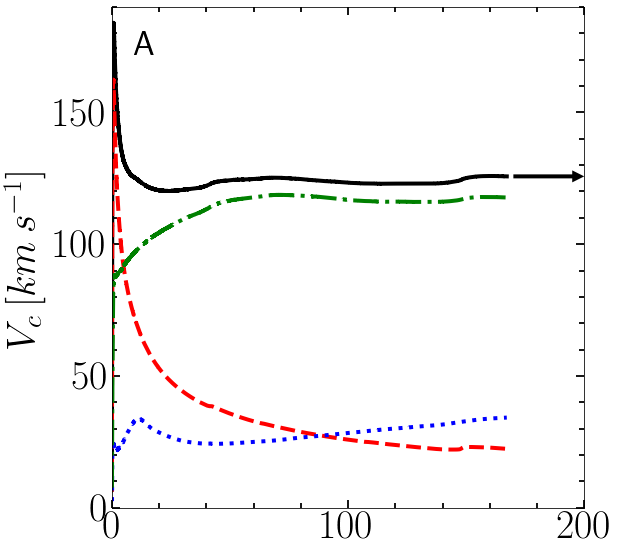

In [13]:
# fig=plt.figure(1,figsize=(16,16))
# fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.95, top = 0.95, wspace=0., hspace= 0)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.92, top = 0.95, wspace=0., hspace= 0)

# ax=fig.add_subplot(221)
ax.plot(rtot_M31gd[np.where(Vtot_M31gd!=0)],Vtot_M31gd[np.where(Vtot_M31gd!=0)],'-', lw=4, color='k', label= 'Total')
ax.plot(rstr_M31gd[np.where(Vstr_M31gd!=0)],Vstr_M31gd[np.where(Vstr_M31gd!=0)],'--',lw=4, color='r', label ='Stars')
ax.plot(rgas_M31gd[np.where(Vgas_M31gd!=0)],Vgas_M31gd[np.where(Vgas_M31gd!=0)],':', color ='b',lw=4, label='Gas')
ax.plot(rdrk_M31gd[np.where(Vdrk_M31gd!=0)],Vdrk_M31gd[np.where(Vdrk_M31gd!=0)],'-.',color='g', lw=4, label='Dark Matter')

ax.text(18, 175, 'A', fontsize=35, color='k', ha='right', va='center')
#plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
# ax[0,0].set_xticklabels([])
# ax[0,0].set_xticks([0,5,10,15])
ax.set_ylabel(r'$V_{c}\:[km\:s^{-1}]$', fontsize=40)
ax.set_ylim(0,190)
ax.set_xlim(0,200)
ax.minorticks_on()
ax.tick_params( labelsize=40)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax.annotate('', xy=(200,Vtot_M31gd[np.where(Vtot_M31gd!=0)][-1]), xytext=(170, Vtot_M31gd[np.where(Vtot_M31gd!=0)][-1]), textcoords='data' ,ha="right", va='center',
             arrowprops=dict(facecolor='k',ec="none"))
# ax[0,0].text(17, Vtot_M31gd[np.where(Vtot_M31gd!=0)][-1], r'$V_{vir}$', fontsize=30, color='deeppink', ha='right', va='center')
# ax[0,0].text(15, 37, 'Gas', fontsize=30, color='b', ha='center', va='center')
# ax[0,0].text(15, 67, 'Stars', fontsize=30, color='r', ha='center', va='center')
# ax[0,0].text(10, 105, 'Dark Matter', fontsize=30, color='g', ha='center', va='center')
# ax[0,0].text(10, 130, 'Total', fontsize=30, color='k', ha='center', va='center')
# ax[0,0].set_title('GADGET', loc='center', fontsize=30)
plt.show()